In [1]:
import esm
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch import nn

### Training
This notebook contains the training processes for BugBuster using three different levels of weight freezing on ESM:
1. [Completely Frozen](#training-with-frozen-esm-layers)
2. [Completely Trainable](#training-with-unfrozen-esm-layers)
3. [Low-Rank Adaptation (LoRA)](#training-with-lora)

### Training with frozen ESM layers

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from BugBuster import BugBuster

model = BugBuster(num_mlm_layers=6, num_classes=1, num_heads=8, num_layers=2, dropout=0.2, freeze_mlm = True)
model.to(device)

/home/jmontour15/miniconda3/envs/faesm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


BugBuster(
  (ProteinMLM): ESM2(
    (embed_tokens): Embedding(33, 320, padding_idx=1)
    (layers): ModuleList(
      (0-5): 6 x TransformerLayer(
        (self_attn): MultiheadAttention(
          (k_proj): Linear(in_features=320, out_features=320, bias=True)
          (v_proj): Linear(in_features=320, out_features=320, bias=True)
          (q_proj): Linear(in_features=320, out_features=320, bias=True)
          (out_proj): Linear(in_features=320, out_features=320, bias=True)
          (rot_emb): RotaryEmbedding()
        )
        (self_attn_layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        (fc1): Linear(in_features=320, out_features=1280, bias=True)
        (fc2): Linear(in_features=1280, out_features=320, bias=True)
        (final_layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
      )
    )
    (contact_head): ContactPredictionHead(
      (regression): Linear(in_features=120, out_features=1, bias=True)
      (activation): Sigmoid()
    

In [4]:
train_data = pd.read_csv("Data/train_data.csv")
val_data = pd.read_csv("Data/val_data.csv")
test_data = pd.read_csv("Data/test_data.csv")

In [5]:
from ARGDataset import ARGDataset

train_dataset = ARGDataset(train_data["sequence"], train_data["label"])
val_dataset = ARGDataset(val_data["sequence"], val_data["label"])
test_dataset = ARGDataset(test_data["sequence"], test_data["label"])

In [6]:
# Access model's batch_converter
batch_converter = model.batch_converter

def collate_fn(batch):
    """
    Custom collate function that tokenizes sequences using ESM's batch_converter 
    and generates an attention mask.
    """
    sequences, labels = zip(*batch)  # Unpack sequences and labels
    
    # Convert batch to tokenized tensors with padding
    batch_labels, batch_strs, batch_tokens = batch_converter(list(zip(range(len(sequences)), sequences)))

    # Create attention mask: 1 for valid tokens, 0 for padding
    attention_mask = (batch_tokens != 1).long()

    return batch_tokens, attention_mask, torch.tensor(labels, dtype=torch.long)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn = collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn = collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn = collate_fn)

In [8]:
def train_model(model, train_loader, val_loader, epochs, patience, device):
    # Send model to GPU
    model.to(device)

    # Initialize loss function and optimizer
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)

    # Early stopping functionality
    best_val_loss = float('inf')
    early_stop_counter = 0

    # Initialize loss storage for analysis
    train_loss_vals = []
    val_loss_vals = []

    for epoch in range(epochs):
        # Call train_step for training
        train_loss = model.train_step(train_loader, loss_fn, optimizer, device)
        # Call test_step for validation
        current_val_loss = model.test_step(val_loader, loss_fn, device)
        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Validation Loss: {current_val_loss:.4f}")
        train_loss_vals.append(train_loss)
        val_loss_vals.append(current_val_loss)

        # Early stopping logic
        if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping triggered. No improvement in validation loss for {patience} epochs.")
            return train_loss_vals, val_loss_vals
    return train_loss_vals, val_loss_vals

In [12]:
train_loss_values, validation_loss_values = train_model(model, train_loader, val_loader, epochs=30, patience=3, device=device)



alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:26<00:00,  8.25it/s]

Epoch 1 | Train Loss: 0.4014 | Validation Loss: 0.3054




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:26<00:00,  8.16it/s]

Epoch 2 | Train Loss: 0.2924 | Validation Loss: 0.2760




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:26<00:00,  8.16it/s]

Epoch 3 | Train Loss: 0.2657 | Validation Loss: 0.2646




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:26<00:00,  8.24it/s]

Epoch 4 | Train Loss: 0.2491 | Validation Loss: 0.2539




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:32<00:00,  6.74it/s]

Epoch 5 | Train Loss: 0.2351 | Validation Loss: 0.2460




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:26<00:00,  8.15it/s]

Epoch 6 | Train Loss: 0.2251 | Validation Loss: 0.2407




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:26<00:00,  8.13it/s]

Epoch 7 | Train Loss: 0.2156 | Validation Loss: 0.2360




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:26<00:00,  8.21it/s]

Epoch 8 | Train Loss: 0.2072 | Validation Loss: 0.2308




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:26<00:00,  8.27it/s]

Epoch 9 | Train Loss: 0.1986 | Validation Loss: 0.2240




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:26<00:00,  8.08it/s]

Epoch 10 | Train Loss: 0.1932 | Validation Loss: 0.2249




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:27<00:00,  7.97it/s]

Epoch 11 | Train Loss: 0.1864 | Validation Loss: 0.2206




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:28<00:00,  7.64it/s]

Epoch 12 | Train Loss: 0.1822 | Validation Loss: 0.2181




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:30<00:00,  6.98it/s]

Epoch 13 | Train Loss: 0.1758 | Validation Loss: 0.2294




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:29<00:00,  7.29it/s]

Epoch 14 | Train Loss: 0.1713 | Validation Loss: 0.2178




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:31<00:00,  6.75it/s]

Epoch 15 | Train Loss: 0.1677 | Validation Loss: 0.2146




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:29<00:00,  7.38it/s]

Epoch 16 | Train Loss: 0.1627 | Validation Loss: 0.2128




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:30<00:00,  7.11it/s]

Epoch 17 | Train Loss: 0.1578 | Validation Loss: 0.2120




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:26<00:00,  8.18it/s]

Epoch 18 | Train Loss: 0.1555 | Validation Loss: 0.2167




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:26<00:00,  8.17it/s]

Epoch 19 | Train Loss: 0.1505 | Validation Loss: 0.2132




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:26<00:00,  8.16it/s]

Epoch 20 | Train Loss: 0.1476 | Validation Loss: 0.2098




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:43<00:00,  4.93it/s]

Epoch 21 | Train Loss: 0.1427 | Validation Loss: 0.2089




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:27<00:00,  7.90it/s]

Epoch 22 | Train Loss: 0.1384 | Validation Loss: 0.2101




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:26<00:00,  8.12it/s]

Epoch 23 | Train Loss: 0.1354 | Validation Loss: 0.2113




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:26<00:00,  8.14it/s]

Epoch 24 | Train Loss: 0.1315 | Validation Loss: 0.2209
Early stopping triggered. No improvement in validation loss for 3 epochs.


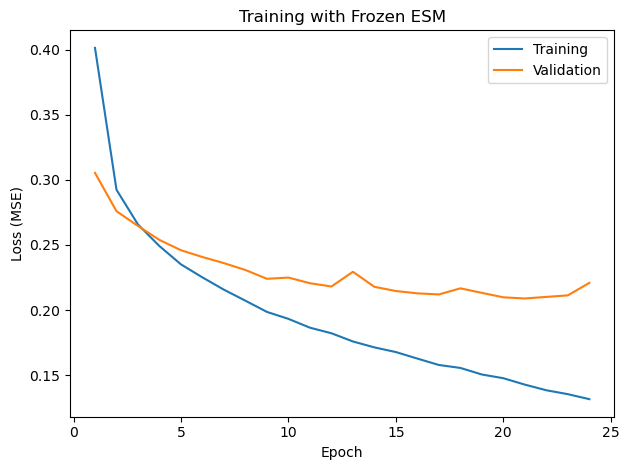

In [15]:
epochs = np.arange(1, len(train_loss_values)+1, 1)
plt.figure()
plt.plot(epochs, train_loss_values, label="Training")
plt.plot(epochs, validation_loss_values, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss (BCE)")
plt.title("Training with Frozen ESM")
plt.legend()
plt.tight_layout()
plt.savefig("Figures/Loss curve (6-8-2)")


00%|█████████████████████████████████████████████████████████████████████████████████| 216/216 [00:25<00:00,  8.34it/s]

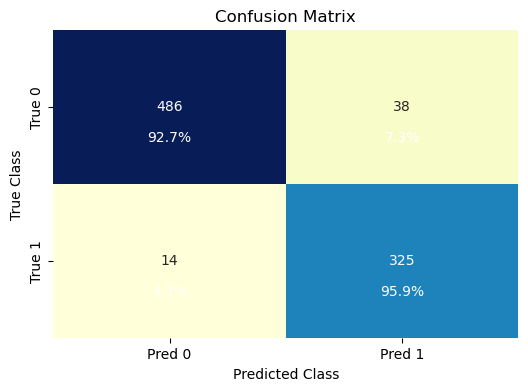

              precision    recall  f1-score   support

           0     0.9720    0.9275    0.9492       524
           1     0.8953    0.9587    0.9259       339

    accuracy                         0.9397       863
   macro avg     0.9337    0.9431    0.9376       863
weighted avg     0.9419    0.9397    0.9401       863



In [22]:
from sklearn.metrics import confusion_matrix, classification_report

# Set the model to evaluation mode
model.eval()

y_true, y_pred = [], []

# Collect true labels and predictions
with torch.no_grad():
    for sequences, attention_masks, targets in tqdm(test_loader):
        sequences, attention_masks, targets = sequences.to(device), attention_masks.to(device), targets.to(device)
        
        # Get model predictions
        outputs = model(sequences, attention_mask=attention_masks)

        # Convert logits to class labels
        predicted = (torch.sigmoid(outputs) > 0.5).long().cpu().numpy().flatten()
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(predicted)

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Combine total amounts and percentages
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        annot[i, j] = f"{cm[i, j]} ({cm_percentage[i, j]:.1f}%)"

# Plot the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=annot, fmt='', cmap='YlGnBu', xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Print classification report
print(classification_report(y_true, y_pred))

In [24]:
# Save checkpoint for later use
torch.save(model.state_dict(), f"trained_checkpoints/mlm6_heads8_layers2.pth")

### Training with unfrozen ESM layers
Since this model will use the same ESM batch converter, we do not need to reinitialize data

In [11]:
model = BugBuster(num_mlm_layers=6, num_classes=1, num_heads=8, num_layers=2, dropout=0.2, freeze_mlm = False)
model.to(device)

BugBuster(
  (ProteinMLM): ESM2(
    (embed_tokens): Embedding(33, 320, padding_idx=1)
    (layers): ModuleList(
      (0-5): 6 x TransformerLayer(
        (self_attn): MultiheadAttention(
          (k_proj): Linear(in_features=320, out_features=320, bias=True)
          (v_proj): Linear(in_features=320, out_features=320, bias=True)
          (q_proj): Linear(in_features=320, out_features=320, bias=True)
          (out_proj): Linear(in_features=320, out_features=320, bias=True)
          (rot_emb): RotaryEmbedding()
        )
        (self_attn_layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        (fc1): Linear(in_features=320, out_features=1280, bias=True)
        (fc2): Linear(in_features=1280, out_features=320, bias=True)
        (final_layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
      )
    )
    (contact_head): ContactPredictionHead(
      (regression): Linear(in_features=120, out_features=1, bias=True)
      (activation): Sigmoid()
    

In [12]:
train_loss_values, validation_loss_values = train_model(model, train_loader, val_loader, epochs=30, patience=3, device=device)



alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:33<00:00,  6.37it/s]

Epoch 1 | Train Loss: 0.3993 | Validation Loss: 0.3043




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:33<00:00,  6.52it/s]

Epoch 2 | Train Loss: 0.2850 | Validation Loss: 0.2665




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:33<00:00,  6.38it/s]

Epoch 3 | Train Loss: 0.2592 | Validation Loss: 0.2566




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:35<00:00,  6.14it/s]

Epoch 4 | Train Loss: 0.2445 | Validation Loss: 0.2589




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:30<00:00,  6.99it/s]

Epoch 5 | Train Loss: 0.2313 | Validation Loss: 0.2441




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:32<00:00,  6.59it/s]

Epoch 6 | Train Loss: 0.2220 | Validation Loss: 0.2365




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:26<00:00,  8.08it/s]

Epoch 7 | Train Loss: 0.2147 | Validation Loss: 0.2315




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:34<00:00,  6.18it/s]

Epoch 8 | Train Loss: 0.2065 | Validation Loss: 0.2288




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:34<00:00,  6.28it/s]

Epoch 9 | Train Loss: 0.1993 | Validation Loss: 0.2290




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:32<00:00,  6.73it/s]

Epoch 10 | Train Loss: 0.1932 | Validation Loss: 0.2257




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:33<00:00,  6.54it/s]

Epoch 11 | Train Loss: 0.1863 | Validation Loss: 0.2269




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:29<00:00,  7.23it/s]

Epoch 12 | Train Loss: 0.1818 | Validation Loss: 0.2197




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:32<00:00,  6.69it/s]

Epoch 13 | Train Loss: 0.1772 | Validation Loss: 0.2213




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:26<00:00,  8.27it/s]

Epoch 14 | Train Loss: 0.1726 | Validation Loss: 0.2193




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:26<00:00,  8.27it/s]

Epoch 15 | Train Loss: 0.1662 | Validation Loss: 0.2344




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:26<00:00,  8.26it/s]

Epoch 16 | Train Loss: 0.1624 | Validation Loss: 0.2122




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:26<00:00,  8.27it/s]

Epoch 17 | Train Loss: 0.1576 | Validation Loss: 0.2174




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:26<00:00,  8.28it/s]

Epoch 18 | Train Loss: 0.1516 | Validation Loss: 0.2200




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:26<00:00,  8.28it/s]

Epoch 19 | Train Loss: 0.1491 | Validation Loss: 0.2186
Early stopping triggered. No improvement in validation loss for 3 epochs.


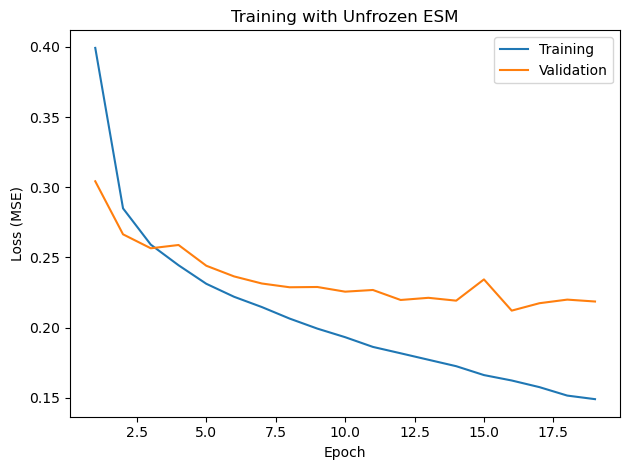

In [13]:
epochs = np.arange(1, len(train_loss_values)+1, 1)
plt.figure()
plt.plot(epochs, train_loss_values, label="Training")
plt.plot(epochs, validation_loss_values, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss (BCE)")
plt.title("Training with Unfrozen ESM")
plt.legend()
plt.tight_layout()
plt.savefig("Figures/Loss curve unfrozen (6-8-2)")


00%|█████████████████████████████████████████████████████████████████████████████████| 216/216 [00:14<00:00, 14.53it/s]

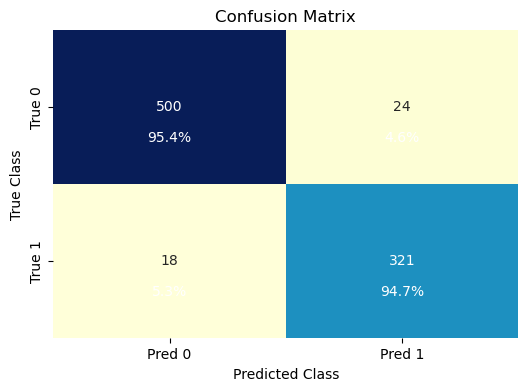

              precision    recall  f1-score   support

           0     0.9653    0.9542    0.9597       524
           1     0.9304    0.9469    0.9386       339

    accuracy                         0.9513       863
   macro avg     0.9478    0.9506    0.9491       863
weighted avg     0.9516    0.9513    0.9514       863



In [14]:
# Set the model to evaluation mode
model.eval()

y_true, y_pred = [], []

# Collect true labels and predictions
with torch.no_grad():
    for sequences, attention_masks, targets in tqdm(test_loader):
        sequences, attention_masks, targets = sequences.to(device), attention_masks.to(device), targets.to(device)
        
        # Get model predictions
        outputs = model(sequences, attention_mask=attention_masks)

        # Convert logits to class labels
        predicted = (torch.sigmoid(outputs) > 0.5).long().cpu().numpy().flatten()
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(predicted)

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Combine total amounts and percentages
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        annot[i, j] = f"{cm[i, j]} ({cm_percentage[i, j]:.1f}%)"

# Plot the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=annot, fmt='', cmap='YlGnBu', xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Print classification report
print(classification_report(y_true, y_pred))

In [15]:
# Save checkpoint for later use
torch.save(model.state_dict(), f"trained_checkpoints/unfrozen_mlm6_heads8_layers2.pth")

### Training with LoRA

In [9]:
model = BugBuster(num_mlm_layers=6, num_classes=1, num_heads=8, num_layers=2, dropout=0.2, freeze_mlm = True, LoRA = True)
model.to(device)

BugBuster(
  (ProteinMLM): PeftModel(
    (base_model): LoraModel(
      (model): ESM2(
        (embed_tokens): Embedding(33, 320, padding_idx=1)
        (layers): ModuleList(
          (0-5): 6 x TransformerLayer(
            (self_attn): MultiheadAttention(
              (k_proj): lora.Linear(
                (base_layer): Linear(in_features=320, out_features=320, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=320, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=320, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (v_proj): lora.Linear(
            

In [10]:
train_loss_values, validation_loss_values = train_model(model, train_loader, val_loader, epochs=30, patience=3, device=device)



alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:24<00:00,  8.87it/s]

Epoch 1 | Train Loss: 0.4088 | Validation Loss: 0.3044




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:24<00:00,  8.85it/s]

Epoch 2 | Train Loss: 0.2879 | Validation Loss: 0.2740




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:24<00:00,  8.87it/s]

Epoch 3 | Train Loss: 0.2619 | Validation Loss: 0.2633




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:24<00:00,  8.85it/s]

Epoch 4 | Train Loss: 0.2459 | Validation Loss: 0.2528




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:24<00:00,  8.90it/s]

Epoch 5 | Train Loss: 0.2330 | Validation Loss: 0.2469




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:24<00:00,  8.88it/s]

Epoch 6 | Train Loss: 0.2223 | Validation Loss: 0.2425




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:24<00:00,  8.90it/s]

Epoch 7 | Train Loss: 0.2139 | Validation Loss: 0.2368




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:24<00:00,  8.98it/s]

Epoch 8 | Train Loss: 0.2077 | Validation Loss: 0.2357




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:23<00:00,  9.02it/s]

Epoch 9 | Train Loss: 0.2022 | Validation Loss: 0.2293




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:23<00:00,  9.03it/s]

Epoch 10 | Train Loss: 0.1954 | Validation Loss: 0.2289




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:23<00:00,  9.01it/s]

Epoch 11 | Train Loss: 0.1921 | Validation Loss: 0.2272




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:23<00:00,  9.03it/s]

Epoch 12 | Train Loss: 0.1862 | Validation Loss: 0.2209




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:24<00:00,  8.88it/s]

Epoch 13 | Train Loss: 0.1828 | Validation Loss: 0.2246




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:25<00:00,  8.54it/s]

Epoch 14 | Train Loss: 0.1782 | Validation Loss: 0.2310




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:24<00:00,  8.89it/s]

Epoch 15 | Train Loss: 0.1730 | Validation Loss: 0.2201




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:23<00:00,  9.00it/s]

Epoch 16 | Train Loss: 0.1689 | Validation Loss: 0.2373




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:23<00:00,  9.01it/s]

Epoch 17 | Train Loss: 0.1672 | Validation Loss: 0.2244




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:24<00:00,  8.84it/s]

Epoch 18 | Train Loss: 0.1615 | Validation Loss: 0.2195




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:24<00:00,  8.91it/s]

Epoch 19 | Train Loss: 0.1582 | Validation Loss: 0.2218




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:24<00:00,  8.92it/s]

Epoch 20 | Train Loss: 0.1550 | Validation Loss: 0.2214




alidating: 100%|█████████████████████████████████████████████████████████████████████| 216/216 [00:24<00:00,  8.91it/s]

Epoch 21 | Train Loss: 0.1508 | Validation Loss: 0.2266
Early stopping triggered. No improvement in validation loss for 3 epochs.


In [11]:
# Merge LoRA layers with model to create final checkpoint
model.ProteinMLM = model.ProteinMLM.merge_and_unload()

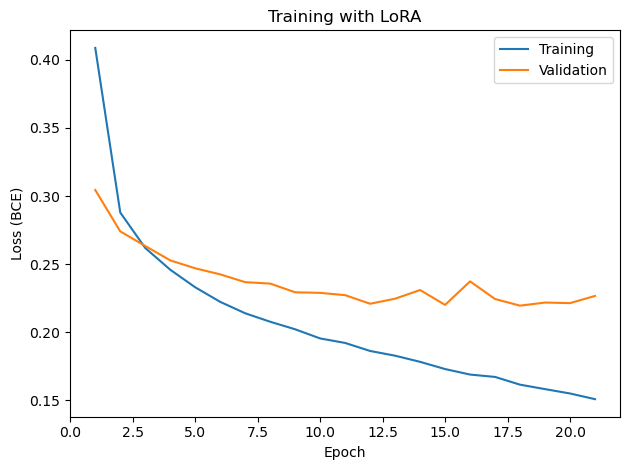

In [12]:
epochs = np.arange(1, len(train_loss_values)+1, 1)
plt.figure()
plt.plot(epochs, train_loss_values, label="Training")
plt.plot(epochs, validation_loss_values, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss (BCE)")
plt.title("Training with LoRA")
plt.legend()
plt.tight_layout()
plt.savefig("Figures/Loss curve LoRA (6-8-2)")


00%|█████████████████████████████████████████████████████████████████████████████████| 216/216 [00:18<00:00, 11.87it/s]

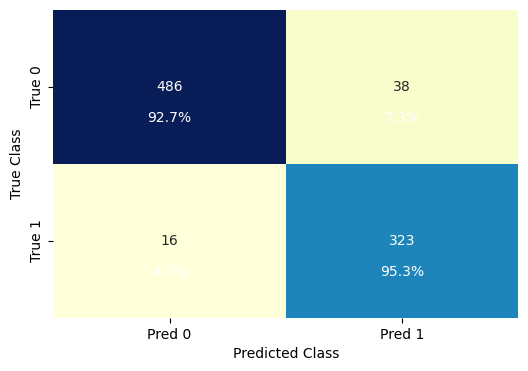

              precision    recall  f1-score   support

           0     0.9681    0.9275    0.9474       524
           1     0.8947    0.9528    0.9229       339

    accuracy                         0.9374       863
   macro avg     0.9314    0.9401    0.9351       863
weighted avg     0.9393    0.9374    0.9377       863



In [13]:
# Set the model to evaluation mode
model.eval()

y_true, y_pred = [], []

# Collect true labels and predictions
with torch.no_grad():
    for sequences, attention_masks, targets in tqdm(test_loader):
        sequences, attention_masks, targets = sequences.to(device), attention_masks.to(device), targets.to(device)
        
        # Get model predictions
        outputs = model(sequences, attention_mask=attention_masks)

        # Convert logits to class labels
        predicted = (torch.sigmoid(outputs) > 0.5).long().cpu().numpy().flatten()
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(predicted)

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Combine total amounts and percentages
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        annot[i, j] = f"{cm[i, j]} ({cm_percentage[i, j]:.1f}%)"

# Plot the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=annot, fmt='', cmap='YlGnBu', xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Print classification report
print(classification_report(y_true, y_pred))

In [14]:
# Save checkpoint for later use
torch.save(model.state_dict(), f"trained_checkpoints/LoRA_mlm6_heads8_layers2.pth")